# Case Study: NTSB Reports

This notebook provides an example of MIKA capabilties via a case study on NTSB reports.
The capabilities shown in this example include:
- Information Retrieval 
- Topic Modeling
- FMEA extraction through custom NER
- Trend Analysis

## Case Study set up:

- Package imports
- Data import

In [1]:

import sys, os
#sys.path.append(os.path.join(os.path.dirname(os.path.realpath(__file__)),"..","..")) #not working in notebook
sys.path.append(os.path.join("..",".."))
import numpy as np
import pandas as pd
from mika.utils import Data
from mika.ir import search
from datetime import datetime as dt
from mika.kd.topic_model_plus import Topic_Model_plus
from mika.kd.trend_analysis import plot_frequency_time_series, plot_metric_time_series, plot_metric_averages, make_pie_chart, chi_squared_tests, plot_risk_matrix, get_likelihood_FAA, identify_docs_per_fmea_row, calc_severity_per_hazard, add_hazards_to_docs, chi_squared_tests
from mika.kd import FMEA
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from torch import cuda
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
os.chdir('../')
os.chdir('../')

In [3]:
ntsb_filepath = os.path.join("data/NTSB/ntsb_full.csv")
ntsb_text_columns = ['narr_cause', 'narr_accf'] # narrative accident cause and narrative accident final
ntsb_document_id_col = 'ev_id'
ntsb_database_name = 'NTSB'
ntsb_data = Data()
ntsb_data.load(ntsb_filepath, preprocessed=False, id_col=ntsb_document_id_col, text_columns=ntsb_text_columns.copy(), name=ntsb_database_name, load_kwargs={'dtype':str})
ntsb_data.prepare_data(create_ids=False, combine_columns=ntsb_text_columns.copy(), remove_incomplete_rows=False)

Combining Columns…: 100%|██████████| 196535/196535 [00:04<00:00, 41292.74it/s]


data preparation:  0.08 minutes 



In [4]:
years_of_interest = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
ntsb_data.data_df = ntsb_data.data_df.loc[ntsb_data.data_df['ev_year'].isin(years_of_interest)].drop_duplicates(subset='ev_id', keep="last").reset_index(drop=True) # keep the last record, this one has the phase of flight and mishap right before the accident
ntsb_data._Data__update_ids()
ntsb_data.data_df

,ev_id,damage,ev_highest_injury,inj_tot_f,ev_date,ev_year,ev_state,wind_dir_ind,wind_vel_ind,light_cond,...,narr_accf,narr_cause,acft_make,acft_model,flt_plan_filed,flight_plan_activated,total_seats,Phase,Mishap Category,Combined Text
0,20110103X01024,SUBS,FATL,1.0,2011-01-01 00:00:00,2011,MA,U,F,NITE,...,The pilot and passenger were on a pleasure fli...,The pilot did not maintain separation from tre...,CESSNA,310F,NONE,,4.0,Approach-VFR Pattern Final,Control flight into terr/obj,The pilot did not maintain separation from tre...
1,20110103X35259,SUBS,FATL,1.0,2011-01-04 00:00:00,2011,MO,U,F,NITE,...,The accident occurred during the fourth leg of...,The pilot's loss of control for undetermined r...,CESSNA,172H,NONE,,4.0,Enroute-Cruise,Loss of control in flight,The pilot's loss of control for undetermined r...
2,20110103X42941,SUBS,SERS,0.0,2011-01-03 00:00:00,2011,PA,U,F,NITE,...,The instrument-rated pilot was on the return l...,The pilot's failure to maintain clearance from...,PIPER,PA-28-161,NONE,N,4.0,Enroute-Cruise,Control flight into terr/obj,The pilot's failure to maintain clearance from...
3,20110103X63632,SUBS,NONE,0.0,2011-01-02 00:00:00,2011,NM,U,F,DAYL,...,The pilot stated that during landing he lost d...,The pilot's failure to maintain directional co...,BELLANCA,1419,NONE,N,4.0,Landing-Landing Roll,Landing gear collapse,The pilot's failure to maintain directional co...
4,20110104X52154,SUBS,NONE,0.0,2011-01-04 00:00:00,2011,AZ,U,F,DAYL,...,"While parking the airplane, the student pilot ...",The student pilot's failure to maintain cleara...,PIPER,PA-28-181,NONE,,4.0,Taxi-from Runway,Collision with terr/obj (non-CFIT),The student pilot's failure to maintain cleara...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16909,20200908X33742,SUBS,FATL,3.0,2020-09-08 00:00:00,2020,TN,U,F,DAYL,...,,,Piper,PA28,NONE,N,4.0,Uncontrolled Descent,Collision with terr/obj (non-CFIT),
16910,20210929103995,SUBS,MINR,0.0,2021-09-28 00:00:00,2021,FL,U,F,DAYL,...,,,ROBINSON HELICOPTER COMPANY,R44 II,,,4.0,Standing-Engine(s) Operating,Loss of control on ground,
16911,20190826X12752,SUBS,NONE,0.0,2019-08-26 00:00:00,2019,CA,U,F,NDRK,...,,,Lockheed,C130,VFIF,Y,7.0,Initial Climb,Part(s) separation from AC,
16912,20200823X00819,SUBS,NONE,0.0,2020-08-22 00:00:00,2020,NC,U,F,DAYL,...,,,Aeronca,11AC,NONE,,2.0,Landing-Landing Roll,Collision with terr/obj (non-CFIT),


# Information Retrieval
Two model options are available for IR:
1. fine-tuned model
2. pre-trained distilroberta model

In [5]:
# fine tuned model
model = SentenceTransformer(os.path.join('models', 'fine_tuned_llis_model'))
#model = SentenceTransformer('all-distilroberta-v1') #uncomment to use pretrained model
query = 'fatigue crack'
ir_ntsb = search('narr_cause', ntsb_data, model)
embeddings_path = os.path.join('data', 'NTSB', 'ntsb_sentence_embeddings_finetune.npy')
ir_ntsb.get_sentence_embeddings(embeddings_path) # uncomment this if the embeddings do not yet exist
#ir_ntsb.load_sentence_embeddings(embeddings_path) # uncomment this if you wish to load sentence embeddings that already exist
queries = ['what components are vulnerable to fatigue crack', 'what are the consequences of a fuel leak', 'what are the risks of low visibility']
for query in queries:
    print(query)
    print(ir_ntsb.run_search(query, return_k=10, rank_k=10))

what components are vulnerable to fatigue crack
   top_hit_idx     top_hit_doc  top_hit_scores  \
0        37185  20121204X63622        0.746134   
1        23081  20141027X62323        0.728395   
2        39995  20141027X62323        0.728395   
3        41744  20160114X73526        0.715234   
4        24830  20160114X73526        0.715234   
5        17989  20110809X03303        0.702911   
6        34903  20110809X03303        0.702911   
7        20253  20121130X01711        0.699882   
8        37167  20121130X01711        0.699882   
9        37185  20121204X63622        0.699882   

                                        top_hit_text  
0  The total loss of engine power as a result of ...  
1  The private pilot and a sport pilot-rated pass...  
2  The loss of engine power during cruise flight ...  
3  Failure of the left wing in flight due to comp...  
4  The sport pilot was conducting a personal cros...  
5  The pilot had just leveled off to cruise fligh...  
6  A sudden loss

# Topic Modeling

Here we implement BERtopic via topic model plus to create a taxonomy of failure information.

In [ ]:
tm = Topic_Model_plus(text_columns=ntsb_text_columns, data=ntsb_data, results_path=os.path.join(os.getcwd(),"examples/Case_Study_NTSB"))
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english") #removes stopwords
BERTkwargs={"top_n_words": 10, 'min_topic_size':25}
tm.bert_topic(count_vectorizor=vectorizer_model, BERTkwargs=BERTkwargs, from_probs=False)
tm.save_bert_model()
tm.save_bert_results(from_probs=False) 
tm.save_bert_taxonomy() #saves taxonomy #takes 15 min to run

In [7]:
taxonomy = pd.read_csv(os.path.join(tm.folder_path,'BERT_taxonomy.csv'), index_col=0) #print taxonomy
taxonomy = taxonomy.dropna(how='any').reset_index(drop=True)
taxonomy

,narr_cause,narr_accf,document IDs for row,number of documents for row
0,"abort, abort takeoff, decision abort, decision...","airplane, pilot reported, pilot, reported, run...","['20120515X10453', '20120531X13740', '20120907...",10
1,"abort, abort takeoff, decision abort, decision...","airplane, pilot, runway, landing, engine, left...","['20110609X25931', '20110706X70339', '20110805...",41
2,"abort, abort takeoff, decision abort, decision...","carburetor, power, engine, carburetor heat, he...","['20120430X00440', '20120514X11605']",2
3,"abort, abort takeoff, decision abort, decision...","fuel, tank, engine, fuel tank, power, tanks, p...","['20111221X54903', '20200920X32151']",2
4,"abort, abort takeoff, decision abort, decision...","snow, airplane, snowcovered, pilot, reported, ...",['20120316X94235'],1
...,...,...,...,...
1149,"wing, left wing, right wing, spar, right, fail...","airplane, pilot reported, pilot, reported, run...","['20120831X90624', '20130829X54643']",2
1150,"wing, left wing, right wing, spar, right, fail...","airplane, pilot, runway, landing, engine, left...","['20110228X83526', '20110919X61206', '20120320...",19
1151,"wing, left wing, right wing, spar, right, fail...","airplane, tailwheelequipped, reported, right, ...",['20200519X04334'],1
1152,"wing, left wing, right wing, spar, right, fail...","flight, pilot, conditions, weather, accident, ...","['20150505X85410', '20180404X13226']",2


# FMEA using Named-Entity Recognition

In [5]:
#definted according to FAA order 8040.4B: https://www.faa.gov/documentLibrary/media/Order/FAA_Order_8040.4B.pdf
def NTSB_severity(damage, inj_level, inj_tot_f, persons_onboard): #damage, ev_highest_injury, inj_tot_f	
    if float(persons_onboard) == 0:
        persons_onboard = inj_tot_f
    if inj_tot_f != 0 :
        pct_fatal = inj_tot_f/persons_onboard
    else:
        pct_fatal = 0
    #minimal: no injuries, no damage. 
    if inj_level == 'NONE' and damage == 'UKN':
        severity = 'Minimal'
    #minor: slight (MINR) damage, physical discomfort
    elif inj_level == 'MINR' or inj_level == 'NONE':
        #major: substaintail (SUBS) damage, injuries
        if damage == 'SUBS':
            severity = 'Major' 
        elif damage == 'DEST':
            severity = 'Hazardous'
        else:
            severity = 'Minor'
    #hazardous: multiple serious injuries, fatalities<2, hull loss (DEST)
    elif inj_level == 'SERS' or (inj_level == 'FATL' and (inj_tot_f <= 2 or pct_fatal < 0.75)) or damage == 'DEST':
        severity = 'Hazardous'
    #catatrophic: fatalities > 2, or num person on board= num fatalities,  hull loss (DEST)
    elif inj_level == 'FATL' and (inj_tot_f > 2 or pct_fatal > 0.75):
        severity = 'Catastrophic'
    else: 
        severity = 'Minimal' #case with no reported fatalities, injury level, or damage level
    return severity

def severity_func(df, numeric=True):
    severity_dict = {'Catastrophic':5, 'Hazardous': 4, 'Major':3, 'Minor':2, 'Minimal':1}
    severities = []
    for i in range(len(df)):
        severities.append(NTSB_severity(df.at[i, 'damage'], df.at[i, 'ev_highest_injury'], float(df.at[i, 'inj_tot_f'].replace('','0')), float(df.at[i, 'total_seats'].replace('','0'))))
    if numeric == True:
        df['severity'] = [severity_dict[severity] for severity in severities]
    else:
        df['severity'] = severities
    return df

In [7]:
#prepare the df for FMEA - drop repeat rows
fmea_input_df = ntsb_data.data_df.copy()
fmea_input_df = fmea_input_df.loc[~(fmea_input_df['Combined Text']=='')].reset_index(drop=True) # remove docs with no text

In [8]:
model_checkpoint = os.path.join("models", "FMEA-ner-model", "checkpoint-1424")
print(model_checkpoint)

device = 'cuda' if cuda.is_available() else 'cpu'
cuda.empty_cache()
print(device)

fmea = FMEA()
fmea.load_model(model_checkpoint)
print("loaded model")
input_data = fmea.load_data('Combined Text','ev_id', df=fmea_input_df, formatted=False)
print("loaded data")
preds = fmea.predict()
df = fmea.get_entities_per_doc()
fmea.group_docs_with_meta(grouping_col='Mishap Category', additional_cols=['Phase'])
fmea.grouped_df.to_csv(os.path.join(os.getcwd(),"examples/Case_Study_NTSB/ntsb_fmea_raw.csv"))

models\FMEA-ner-model\checkpoint-1424
cuda
loaded model


Token indices sequence length is longer than the specified maximum sequence length for this model (3132 > 512). Running this sequence through the model will result in indexing errors


loaded data


In [9]:
fmea.calc_severity(severity_func, from_file=False)
fmea.calc_frequency(year_col="ev_year") #add year column
fmea.calc_risk()
fmea.post_process_fmea(phase_name='Phase', id_name='NTSB', max_words=10)

fmea.fmea_df.astype(str).to_csv(os.path.join(os.getcwd(),"examples/Case_Study_NTSB/NTSB_FMEA.csv"))

In [28]:
mishaps_of_interest = ['Birdstrike','Midair collision', 'Loss of control in flight','Loss of control on ground','Turbulence encounter', 'Ground collision']

In [37]:
fmea.fmea_df.loc[fmea.fmea_df.index.isin(mishaps_of_interest)].astype(str).to_csv(os.path.join(os.getcwd(),"examples/Case_Study_NTSB/NTSB_FMEA_truncated.csv"))
fmea.fmea_df.loc[fmea.fmea_df.index.isin(mishaps_of_interest)]

,Phase,Cause,Failure Mode,Effect,Control Process,Recommendations,Frequency,Severity,Risk,NTSB
cluster,,,,,,,,,,
Birdstrike,Approach-VFR Pattern Downwind; Enroute; Enrout...,"at low, bird, surface, a, red - tailed, hawk, ...","in - flight, collision, with a, bird, large, p...","bird, substantial, damage, large, broke the fr...","was, towed to the gate, a, bird ingestion and ...","see the public, , enter, keep an, eye, on, land,",4,3.0114942528735638,12.045977011494251,20170626X02552
Ground collision,Approach-VFR Pattern Downwind; Standing-Engine...,"', inadequate visual, lookout, failure, zodiac...","to see and avoid the, zodiac was, from the, pr...","hit, rear, vertical stabilize, were, destroyed...","radio, calls, position, reports, checked the t...","inform, , use caution, hold, pilot, clearance,...",4,2.878504672897196,11.514018691588785,20140603X83103
Loss of control in flight,Approach-VFR Pattern Downwind; Approach-IFR Fi...,"pilot's, fatigue, pilot, departed, night, test...","pilot's loss of, entered a, descending left, f...","und, airplane, spiraled, down, impacting an op...","intermediate, stops, radar track, toxicology, ...",", conform to its type, certificate, documentat...",5,3.659551760939168,18.29775880469584,20190713X34059
Loss of control on ground,Approach-VFR Pattern Downwind; Approach-IFR Fi...,"pre - existing crack in the weld, joint, const...","failure of the left main landing gear, st, lef...","the, structural, damage, to the, fuselage, rig...","right ailer, point, applied right rudder to, c...",", remain, reduce, land to the, north, take off...",5,3.0433925049309667,15.216962524654834,20111104X64432
Midair collision,Enroute; Enroute-Descent; Landing; Maneuvering...,failure of both pilots to see and avoid the ot...,"midair, collision, airplanes, collided, collid...","impacted the, terrain, a utility, pole, to, re...","wingtip -, - mounted strobe anticollision, lig...","alter, course, pass well, not have passed over...",3,3.3968253968253967,10.19047619047619,20191205X95005
Turbulence encounter,Approach-VFR Pattern Downwind; Enroute; Enrout...,"with, of, cumulonimbus, clouds, slowly, activi...","and, turbulence, tailwind, knots, tailwind sud...","indicated speed of the airplane quickly, incre...","captain activated the speed, brakes, disengage...",", expect light - to - moderate, before -, cabin",4,3.792307692307692,15.169230769230769,20181001X33722


# Trend Analysis

Now that we have rows of mishaps and failure information, we can look at trends in the mishap. In this case, we look at trends in:
1. mishap frequency over time
2. mishap severity over time
3. average mishap severity
3. distribution of mishaps over activated flight plans
4. distribution of mishaps over visibility conditions

In [6]:
frequency, docs_per_row = identify_docs_per_fmea_row(ntsb_data.data_df, 'Mishap Category', 'ev_year', 'ev_id')

In [7]:
mishaps_of_interest = ['Birdstrike','Midair collision', 'Loss of control in flight','Loss of control on ground','Turbulence encounter', 'Ground collision',]
years_of_interest = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
frequency_set = {mishap:{year: frequency[mishap][year] for year in years_of_interest} for mishap in mishaps_of_interest}
doc_set = {mishap:{year: docs_per_row[mishap][year] for year in years_of_interest} for mishap in mishaps_of_interest}


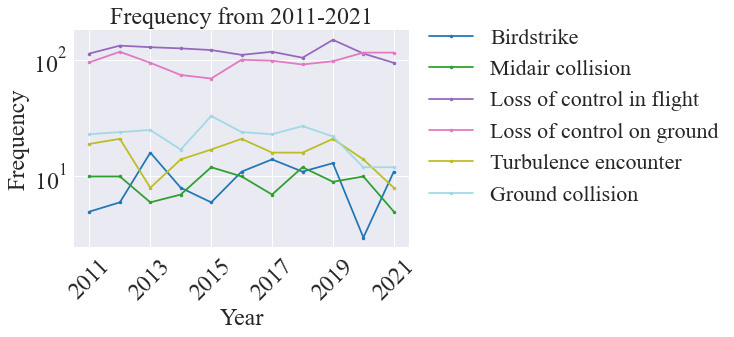

In [8]:
plot_frequency_time_series(frequency_set, metric_name='Frequency', line_styles=[], 
                               markers=[], title="Frequency from 2011-2021", time_name="Year", xtick_freq=2, 
                               scale=False, save=False, yscale='log', legend=True,
                               figsize=(6,4), fontsize=24)

In [9]:
df_with_severities = severity_func(ntsb_data.data_df, numeric=True)

In [10]:
severities, total_severities_hazard = calc_severity_per_hazard(doc_set, df_with_severities, 'ev_id', metric='max')

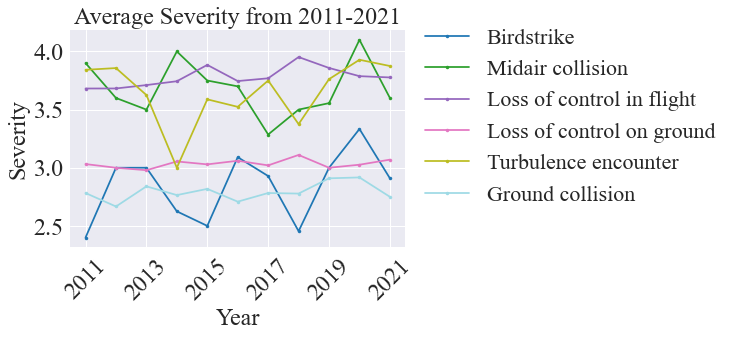

In [11]:
plot_metric_time_series(metric_data=severities, metric_name="Severity", title="Average Severity from 2011-2021", time_name='Year', xtick_freq=2, show_std=False, save=False, figsize=(6,4), fontsize=24)

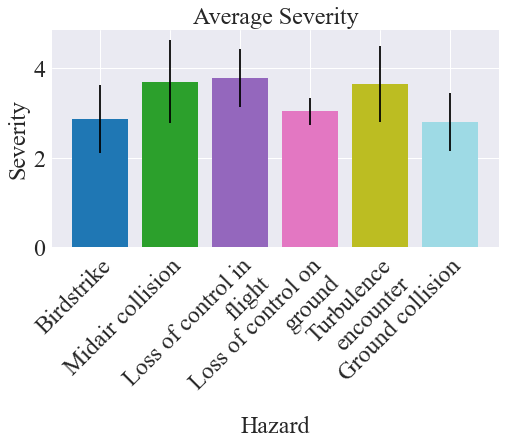

In [12]:
plot_metric_averages(metric_data=severities, metric_name="Severity", show_std=True, title="Average Severity", save=False, legend=False, figsize=(8,4),fontsize=24)

In [13]:
df_with_severities['sky_cond_nonceil'].unique()
sky_conditions_dict = {'CLER': 'clear', 
'':'unknown', 
'SCAT': 'scattered', 
'FEW': 'few', 
'UNK': 'unknown', 
'OVCT': 'thin overcast', 
'OVC': 'overcast',
'OBSC': 'obscured',
'BKNT': 'thin broken', 
'BKN': 'broken',
'POBS': 'partially obscured',
'VV': 'indefinite',
'NONE': 'none'}
df_with_severities['sky_cond_nonceil_cleaned'] = [sky_conditions_dict[cond] for cond in df_with_severities['sky_cond_nonceil'].tolist()]

In [14]:
df_with_severities['flight_plan_activated_cleaned'] = [val if val!='' else 'U' for val in df_with_severities['flight_plan_activated'].tolist()]

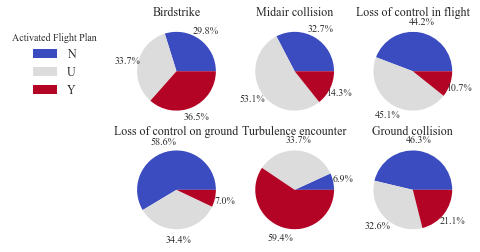

In [15]:
make_pie_chart(doc_set, df_with_severities, 'flight_plan_activated_cleaned', mishaps_of_interest, 'ev_id', 'Activated Flight Plan', save=False, fontsize=12, pie_kwargs={'pctdistance':1.27}, figsize=(6,4), padding=10)

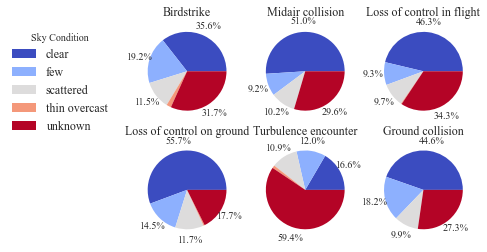

In [16]:
make_pie_chart(doc_set, df_with_severities, 'sky_cond_nonceil_cleaned', mishaps_of_interest, 'ev_id', 'Sky Condition', save=False, fontsize=12, pie_kwargs={'pctdistance':1.27}, figsize=(6,4), padding=10)

In [ ]:
df_with_hazards = add_hazards_to_docs(df_with_severities, id_field='ev_id', docs=doc_set)
stats_df, counts_dfs = chi_squared_tests(df_with_hazards, mishaps_of_interest, predictors=['flight_plan_activated_cleaned','sky_cond_nonceil_cleaned'], pred_dict={'flight_plan_activated_cleaned':'flight plan','sky_cond_nonceil_cleaned': 'sky condition'})

In [18]:
stats_df

Predictor                 flight plan             sky condition            
Measure                         p-val chi-squared         p-val chi-squared
Birdstrike                      0.000      44.813         0.027      10.929
Midair collision                0.007      10.024         0.789       1.710
Loss of control in flight       0.000      30.626         0.000      34.186
Loss of control on ground       0.000      74.891         0.000      65.104
Turbulence encounter            0.000     319.912         0.000      98.286
Ground collision                0.005      10.670         0.040      10.004

In [19]:
for df in counts_dfs:
    display(counts_dfs[df])

N          U          Y
Hazard                    Present                                  
Birdstrike                0         18.343739   4.985338 -23.329077
                          1        -18.343739  -4.985338  23.329077
Midair collision          0         14.496985 -14.321509  -0.175476
                          1        -14.496985  14.321509   0.175476
Loss of control in flight 0         42.169032 -86.260908  44.091877
                          1        -42.169032  86.260908 -44.091877
Loss of control on ground 0       -118.701135  43.465236  75.235899
                          1        118.701135 -43.465236 -75.235899
Turbulence encounter      0         71.030330   8.283020 -79.313350
                          1        -71.030330  -8.283020  79.313350
Ground collision          0          2.819085  14.042805 -16.861890
                          1         -2.819085 -14.042805  16.861890

clear     unknown        few  \
Hazard                    Present                                     
Birdstrike                0        12.706515   -3.719641  -7.401206   
                          1       -12.706515    3.719641   7.401206   
Midair collision          0        -3.161168   -1.408892   2.871940   
                          1         3.161168    1.408892  -2.871940   
Loss of control in flight 0        19.721178  -80.587797  36.090635   
                          1       -19.721178   80.587797 -36.090635   
Loss of control on ground 0       -83.986165  111.842143 -24.983505   
                          1        83.986165 -111.842143  24.983505   
Turbulence encounter      0        54.640771  -54.730164   0.199894   
                          1       -54.640771   54.730164  -0.199894   
Ground collision          0         7.663238    2.133144 -14.683576   
                          1        -7.663238   -2.133144  14.683576   

                                   scattered  thin overcast  
Hazard                    Present                            
Birdstrike                0        -0.237436      -1.348232  
                          1         0.237436       1.348232  
Midair collision          0         1.083954       0.614166  
                          1        -1.083954      -0.614166  
Loss of control in flight 0        20.597552       4.178432  
                          1       -20.597552      -4.178432  
Loss of control on ground 0        -4.546825       1.674353  
                          1         4.546825      -1.674353  
Turbulence encounter      0         0.792775      -0.903275  
                          1        -0.792775       0.903275  
Ground collision          0         3.370581       1.516613  
                          1        -3.370581      -1.516613

In [20]:
severity_dict = {5:'Catastrophic Impact', 4:'Hazardous Impact', 3:'Major Impact', 2:'Minor Impact', 1:'Minimal Impact'}
rm_severities = {hazard: severity_dict[round(total_severities_hazard[hazard])] for hazard in total_severities_hazard}
rates = {hazard: sum([frequency_set[hazard][year] for year in frequency_set[hazard]])/len(years_of_interest) for hazard in frequency_set}
rm_likelihoods = get_likelihood_FAA(rates)

In [21]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["font.family"] = "Times New Roman"

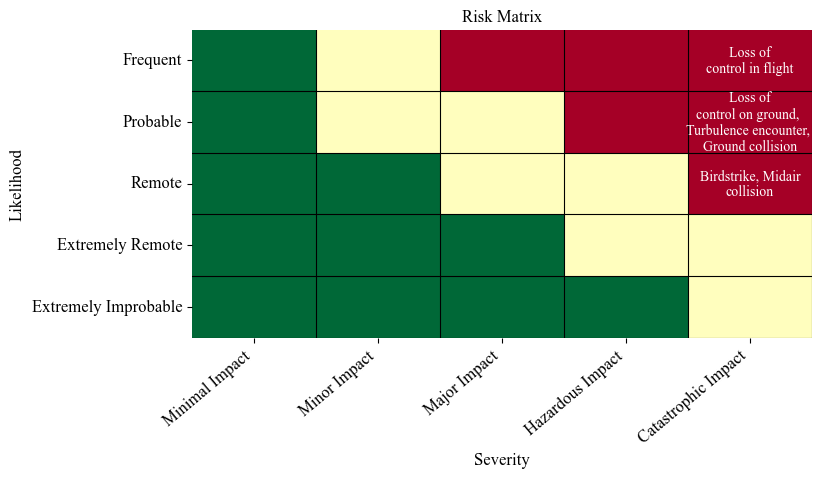

In [22]:
plot_risk_matrix(rm_likelihoods, rm_severities, figsize=(8,4), fontsize=12, max_chars=20, annot_font=10)